In [20]:
# ==============================
# 1. Imports
# ==============================
import pandas as pd
import numpy as np
import logging
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime



In [21]:
# ==============================
# 2. Configuration
# ==============================
class Config:
    TEST_SIZE = 0.2
    SEED = 42
    SCORING = 'accuracy'
    CV_FOLDS = 5
    MODEL_DIR = "/models"

config = Config()



In [22]:
# Setup Logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

In [23]:
# ==============================
# 3. Load Noisy Dataset
# ==============================
logger.info("Loading noisy dataset...")
path='/Users/ashishsingh/Desktop/SENTIMENT_ANALYSIS/data/processed/processed_sentiment_comments_noisy.csv'
df = pd.read_csv(path)



2025-06-01 16:25:14,823 - INFO - Loading noisy dataset...


In [26]:
# ==============================
# 5. Feature Engineering
# ==============================
def prepare_features(df: pd.DataFrame):
    """Prepare features and target."""
    X = df[['Comment', 'Comment_Length', 'Likes', 'Has_Typo', 'Slang_Presence']]
    y = df['Sentiment_Score_Mapped'].astype(int)
    return X, y

X, y = prepare_features(df)

In [25]:
# ==============================
# Mapping Sentiment for Noisy Data (fixed)
# ==============================
sentiment_mapping = {
    -2: 0,  # Angry
    -1: 1,  # Sad
     0: 2,  # Neutral
     1: 3,  # Happy
     2: 4   # Excited
}

df['Sentiment_Score_Mapped'] = df['Sentiment_Score'].map(sentiment_mapping)

# Safely handle missing mappings
df = df.dropna(subset=['Sentiment_Score_Mapped'])  # <--- Drop problematic rows
df['Sentiment_Score_Mapped'] = df['Sentiment_Score_Mapped'].astype(int)

# Now no IntCastingNaNError anymore
X, y = prepare_features(df)

/var/folders/c1/6c8s3wn93nd1yg_s50mdh4nc0000gn/T/ipykernel_4592/2097843323.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment_Score_Mapped'] = df['Sentiment_Score_Mapped'].astype(int)


In [27]:
# ==============================
# 5. Train-Test Split
# ==============================
logger.info("Splitting train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config.TEST_SIZE, random_state=config.SEED, stratify=y
)

logger.info(f"Train size: {X_train.shape}, Test size: {X_test.shape}")



2025-06-01 16:25:31,834 - INFO - Splitting train and test sets...
2025-06-01 16:25:31,839 - INFO - Train size: (1266, 5), Test size: (317, 5)


In [28]:
# ==============================
# 6. Preprocessing Pipeline
# ==============================
text_features = ['Comment']
num_features = ['Comment_Length', 'Likes', 'Has_Typo', 'Slang_Presence']

text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=500))
])

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'Comment'),
        ('num', num_transformer, num_features)
    ]
)



In [29]:
# ==============================
# 7. Models Dictionary
# ==============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=config.SEED),
    "Random Forest": RandomForestClassifier(random_state=config.SEED),
    "Gradient Boosting": GradientBoostingClassifier(random_state=config.SEED),
    "SVM": SVC(probability=True, random_state=config.SEED),
    "XGBoost": XGBClassifier(random_state=config.SEED, use_label_encoder=False, eval_metric='mlogloss'),
    "LightGBM": LGBMClassifier(random_state=config.SEED)
}



In [30]:
# ==============================
# 8. Training and Evaluation
# ==============================
def evaluate_model(model, X_test, y_test):
    """Evaluate model and return metrics."""
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    return acc, f1

results = []

for name, model in models.items():
    logger.info(f"Training {name}...")
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    pipeline.fit(X_train, y_train)
    
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=config.CV_FOLDS, scoring=config.SCORING)
    
    acc, f1 = evaluate_model(pipeline, X_test, y_test)
    
    results.append({
        'Model': name,
        'CV_Mean': np.mean(cv_score),
        'CV_Std': np.std(cv_score),
        'Test_Accuracy': acc,
        'Test_F1': f1,
        'Pipeline': pipeline
    })



2025-06-01 16:25:32,736 - INFO - Training Logistic Regression...
2025-06-01 16:25:32,869 - INFO - Training Random Forest...
2025-06-01 16:25:33,591 - INFO - Training Gradient Boosting...
2025-06-01 16:25:37,141 - INFO - Training SVM...
2025-06-01 16:25:38,653 - INFO - Training XGBoost...
/Users/ashishsingh/Desktop/SENTIMENT_ANALYSIS/env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:25:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ashishsingh/Desktop/SENTIMENT_ANALYSIS/env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:25:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/ashishsingh/Desktop/SENTIMENT_ANALYSIS/env/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [16:25:39] WARNING

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1924
[LightGBM] [Info] Number of data points in the train set: 1266, number of used features: 79
[LightGBM] [Info] Start training from score -1.515996
[LightGBM] [Info] Start training from score -1.320572
[LightGBM] [Info] Start training from score -1.426590
[LightGBM] [Info] Start training from score -1.297179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1596
[LightGBM] [Info] Numb

/Users/ashishsingh/Desktop/SENTIMENT_ANALYSIS/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1592
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 77
[LightGBM] [Info] Start training from score -1.517994
[LightGBM] [Info] Start training from score -1.318553
[LightGBM] [Info] Start training from score -1.427610
[LightGBM] [Info] Start training from score -1.296654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ashishsingh/Desktop/SENTIMENT_ANALYSIS/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1628
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 79
[LightGBM] [Info] Start training from score -1.517994
[LightGBM] [Info] Start training from score -1.318553
[LightGBM] [Info] Start training from score -1.427610
[LightGBM] [Info] Start training from score -1.296654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

/Users/ashishsingh/Desktop/SENTIMENT_ANALYSIS/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ashishsingh/Desktop/SENTIMENT_ANALYSIS/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1603
[LightGBM] [Info] Number of data points in the train set: 1013, number of used features: 77
[LightGBM] [Info] Start training from score -1.513500
[LightGBM] [Info] Start training from score -1.322250
[LightGBM] [Info] Start training from score -1.427610
[LightGBM] [Info] Start training from score -1.296654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/ashishsingh/Desktop/SENTIMENT_ANALYSIS/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/ashishsingh/Desktop/SENTIMENT_ANALYSIS/env/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [31]:
# ==============================
# 9. Results DataFrame
# ==============================
model_comparison = pd.DataFrame(results).sort_values(by='Test_Accuracy', ascending=False)
logger.info(f"\n{model_comparison[['Model', 'CV_Mean', 'CV_Std', 'Test_Accuracy', 'Test_F1']]}")

2025-06-01 16:25:49,536 - INFO - 
                 Model   CV_Mean    CV_Std  Test_Accuracy   Test_F1
1        Random Forest  0.965252  0.010695       0.968454  0.968686
0  Logistic Regression  0.947098  0.015827       0.965300  0.965538
2    Gradient Boosting  0.964467  0.011400       0.965300  0.965498
5             LightGBM  0.943930  0.010645       0.949527  0.949658
4              XGBoost  0.948676  0.013358       0.943218  0.943780
3                  SVM  0.866503  0.026055       0.870662  0.871702


In [32]:
# Ensure writable directory before proceeding
if not os.access(config.MODEL_DIR, os.W_OK):
    import tempfile
    import warnings
    warnings.warn(f"MODEL_DIR '{config.MODEL_DIR}' is not writable. Using temporary directory instead.")
    config.MODEL_DIR = tempfile.mkdtemp(prefix="models_")

# ==============================
# 10. Best Model Selection
# ==============================
best_model_row = model_comparison.iloc[0]
best_model_name = best_model_row['Model']
best_pipeline = best_model_row['Pipeline']

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = os.path.join(config.MODEL_DIR, f"{best_model_name.lower().replace(' ', '_')}_noisy_{timestamp}.pkl")

# Create directory if it doesn't exist
os.makedirs(config.MODEL_DIR, exist_ok=True)

# Save the model
joblib.dump(best_pipeline, model_filename)

logger.info(f"Best Model: {best_model_name}")
logger.info(f"Model saved at {model_filename}")


/var/folders/c1/6c8s3wn93nd1yg_s50mdh4nc0000gn/T/ipykernel_4592/3494343755.py:5: UserWarning: MODEL_DIR '/models' is not writable. Using temporary directory instead.
  warnings.warn(f"MODEL_DIR '{config.MODEL_DIR}' is not writable. Using temporary directory instead.")
2025-06-01 16:25:49,562 - INFO - Best Model: Random Forest
2025-06-01 16:25:49,563 - INFO - Model saved at /var/folders/c1/6c8s3wn93nd1yg_s50mdh4nc0000gn/T/models_i8lag1ou/random_forest_noisy_20250601_162549.pkl


In [33]:
# ==============================
# 10. Best Model Selection
# ==============================
#best_model_row = model_comparison.iloc[0]
#best_model_name = best_model_row['Model']
#best_pipeline = best_model_row['Pipeline']

#timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
#model_filename = os.path.join(config.MODEL_DIR, f"{best_model_name.lower().replace(' ', '_')}_noisy_{timestamp}.pkl")
#os.makedirs(config.MODEL_DIR, exist_ok=True)
#joblib.dump(best_pipeline, model_filename)

#logger.info(f"Best Model: {best_model_name}")
#logger.info(f"Model saved at {model_filename}")




/var/folders/c1/6c8s3wn93nd1yg_s50mdh4nc0000gn/T/ipykernel_4592/2619373217.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


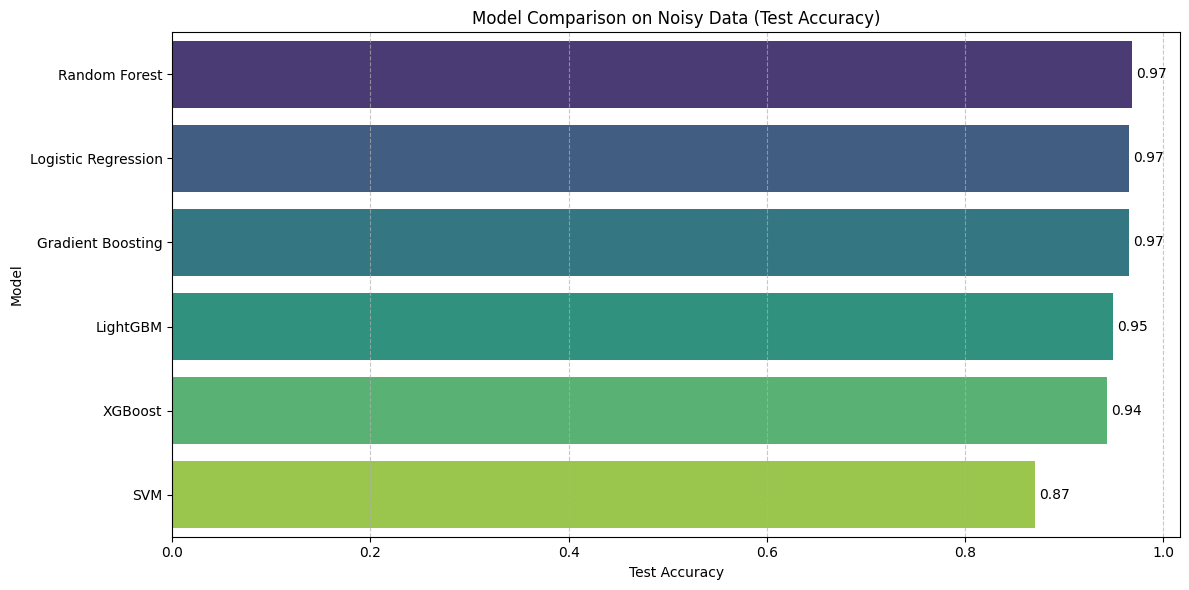

In [34]:
# ==============================
# 11. Visualization
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='Test_Accuracy',
    y='Model',
    data=model_comparison,
    palette='viridis'
)

# Add text annotations on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.title('Model Comparison on Noisy Data (Test Accuracy)')
plt.xlabel('Test Accuracy')
plt.ylabel('Model')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
